In [3]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})
#Importing Intel extension for sklearn to improve speed
from sklearnex import patch_sklearn, unpatch_sklearn
patch_sklearn()
import cudf
import dill

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
#64GB of RAM so no need to compress data
business = pd.read_json("Data/yelp_academic_dataset_business.json", lines=True)
# checkins = pd.read_json("Data/yelp_academic_dataset_checkin.json", lines=True)
reviews = pd.read_json("Data/yelp_academic_dataset_review.json", lines=True)
# tips = pd.read_json("Data/yelp_academic_dataset_tip.json", lines=True)
# users = pd.read_json("Data/yelp_academic_dataset_user.json", lines=True)

business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [3]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [4]:
import re

def restaurant_select(x):
    y = str(x)
    r = re.compile(r'.*Restaurant.*')
    if re.match(r, y):
        return 1
    else:
        return 0
    


business["is_restaurant"] = business["categories"].apply(restaurant_select)

#Keeping only restaurants
business = business[business.is_restaurant == 1]

business = business[["business_id"]]

business

,business_id
3,MTSW4McQd7CbVtyjqoe9mw
5,CF33F8-E6oudUQ46HnavjQ
8,k0hlBqXX-Bt0vf1op7Jr1w
9,bBDDEgkFA1Otx9Lfe7BZUQ
11,eEOYSgkmpB90uNA7lDOMRA
...,...
150325,l9eLGG9ZKpLJzboZq-9LRQ
150327,cM6V90ExQD6KMSU3rRB5ZA
150336,WnT9NIzQgLlILjPT0kEcsQ
150339,2O2K6SXPWv56amqxCECd4w


In [5]:
#Keeping only reviews on restaurants
reviews = pd.merge(reviews, business, on="business_id", how="inner")

#Dropping user_id and business_id
reviews.drop(columns={"user_id", "business_id"}, inplace=True)
reviews.set_index("review_id", inplace=True)

print(reviews.shape)
reviews.head()

(4724684, 6)


,stars,useful,funny,cool,text,date
review_id,,,,,,
KU_O5udG6zpxOg-VcAEodg,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
VJxlBnJmCDIy8DFG0kjSow,2,0,0,0,This is the second time we tried turning point...,2017-05-13 17:06:55
S6pQZQocMB1WHMjTRbt77A,4,2,0,1,The place is cute and the staff was very frien...,2017-08-08 00:58:18
WqgTKVqWVHDHjnjEsBvUgg,3,0,0,0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23
M0wzFFb7pefOPcxeRVbLag,2,0,0,0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47


In [6]:

reviews["text_length"] = reviews["text"].apply(len)

reviews.head()

,stars,useful,funny,cool,text,date,text_length
review_id,,,,,,,
KU_O5udG6zpxOg-VcAEodg,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,513
VJxlBnJmCDIy8DFG0kjSow,2,0,0,0,This is the second time we tried turning point...,2017-05-13 17:06:55,477
S6pQZQocMB1WHMjTRbt77A,4,2,0,1,The place is cute and the staff was very frien...,2017-08-08 00:58:18,216
WqgTKVqWVHDHjnjEsBvUgg,3,0,0,0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23,736
M0wzFFb7pefOPcxeRVbLag,2,0,0,0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47,953


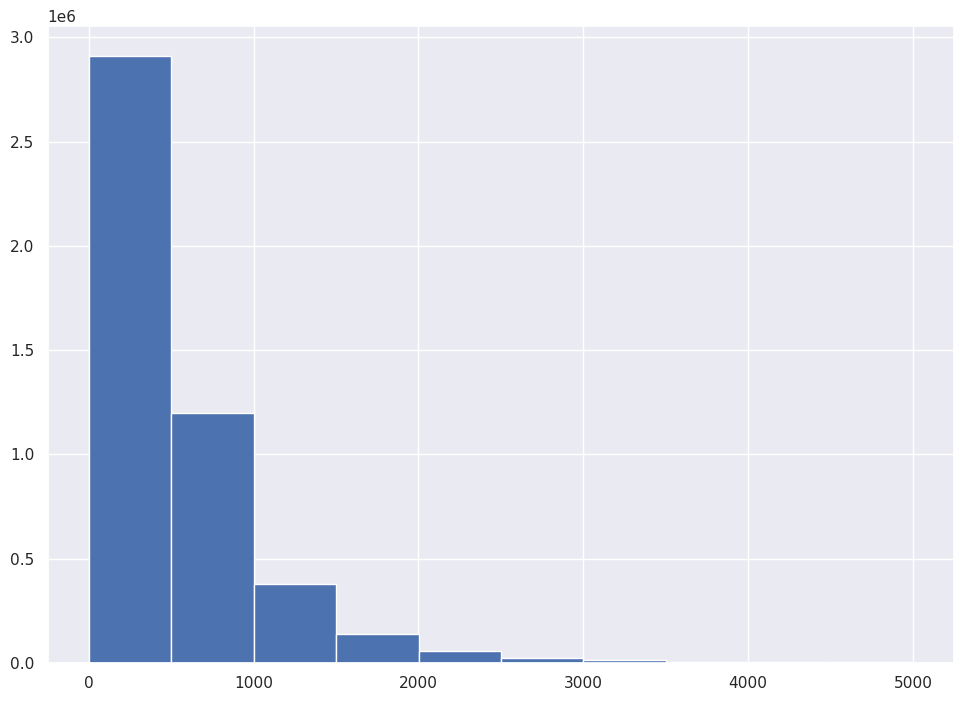

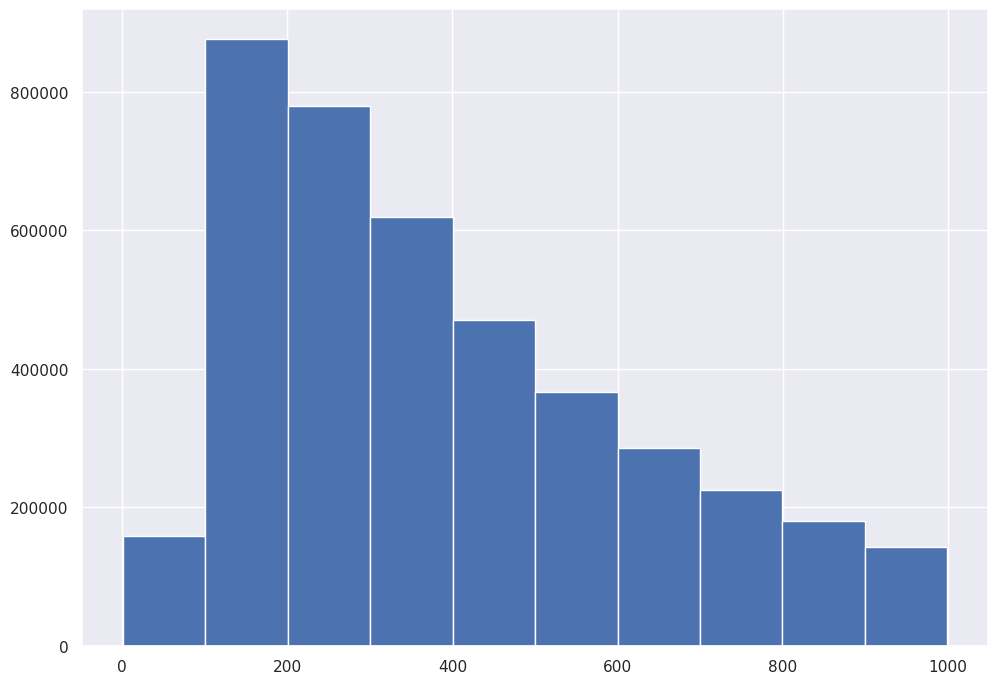

In [7]:
plt.hist(reviews["text_length"])
plt.show()

#looking at the distribution of reviews with less than 1000 words
plt.hist(reviews[reviews.text_length < 1000]["text_length"])
plt.show()

In [8]:
#Looking at reviews with less than 50 words
reviews[reviews.text_length < 50]
#Still some indications (ex. the gluten free pizza is unbeatable), we will not delete these samples
#We will delete reviews with less than 10 characters.

reviews = reviews[reviews.text_length>10]

reviews[reviews.text.isna()]
#No NA values

reviews.info(verbose=True, show_counts=True)

#reviews = cudf.from_pandas(reviews)

reviews.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4724551 entries, KU_O5udG6zpxOg-VcAEodg to nGLcmo0D3IKrqqgK1kutlA
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   stars        4724551 non-null  int64         
 1   useful       4724551 non-null  int64         
 2   funny        4724551 non-null  int64         
 3   cool         4724551 non-null  int64         
 4   text         4724551 non-null  object        
 5   date         4724551 non-null  datetime64[ns]
 6   text_length  4724551 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 288.4+ MB


,stars,useful,funny,cool,text,date,text_length
review_id,,,,,,,
KU_O5udG6zpxOg-VcAEodg,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,513
VJxlBnJmCDIy8DFG0kjSow,2,0,0,0,This is the second time we tried turning point...,2017-05-13 17:06:55,477
S6pQZQocMB1WHMjTRbt77A,4,2,0,1,The place is cute and the staff was very frien...,2017-08-08 00:58:18,216
WqgTKVqWVHDHjnjEsBvUgg,3,0,0,0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23,736
M0wzFFb7pefOPcxeRVbLag,2,0,0,0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47,953


In [17]:
#Using Vader to calculate the polarity of our reviews
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

example = reviews.iloc[3,:]

sentences = example.text.split('.')

#Calculating the difference if we calculate the polarity from all the review or if we split it in sentences
print(analyzer.polarity_scores(example.text)["compound"])

scores = []
for s in sentences:
    scores.append(analyzer.polarity_scores(s)["compound"])
print(np.mean(scores))
#Significant difference !

#Looking at the actual review :
print(sentences)
#Clearly, the review is not that positive and it is even slightly negative

def analyze_polarity(x):
    sentences = str(x).split('.')
    scores = []
    for s in sentences:
        scores.append(analyzer.polarity_scores(s)["compound"])
    return np.mean(scores) 

0.8333
0.12201999999999999
['We came on a Saturday morning after waiting a few months after opening hoping that they would resolve the issues from a new restaurant opening', ' We were seated right away and the server brought water, coffee and took our orders right away', ' We waited over 30 mins for breakfast', " I got the freebird and came out first before my husband's dish", ' While it tastes good, it was just potatoes and the spicy sausage gravy was mostly a sauce', ' There was barely any sausage', ' My husband got the ny deli omelette that had way too much cheese that it overpowered everything and very little pastrami', " Lastly, we were ready to go and our server spent at least 10 mins chatting at another table so I couldn't get our check", " I'm not sure if we will return", '']


In [18]:
reviews["polarity"] = reviews["text"].apply(analyze_polarity)

reviews.head()

,stars,useful,funny,cool,text,date,text_length,polarity
review_id,,,,,,,,
KU_O5udG6zpxOg-VcAEodg,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,513,0.230957
VJxlBnJmCDIy8DFG0kjSow,2,0,0,0,This is the second time we tried turning point...,2017-05-13 17:06:55,477,-0.042017
S6pQZQocMB1WHMjTRbt77A,4,2,0,1,The place is cute and the staff was very frien...,2017-08-08 00:58:18,216,0.371014
WqgTKVqWVHDHjnjEsBvUgg,3,0,0,0,We came on a Saturday morning after waiting a ...,2017-11-19 02:20:23,736,0.122020
M0wzFFb7pefOPcxeRVbLag,2,0,0,0,"Mediocre at best. The decor is very nice, and ...",2017-09-09 17:49:47,953,0.059770


In [26]:

#Removing date and review_id data that we will not exploit to reduce dataframe size

reviews.reset_index(inplace=True)
reviews.drop(columns=["review_id","date"], inplace=True)

#Saving our current reviews file
with open('Data/reviews.pkl', 'wb') as file:
    dill.dump(reviews, file)


In [5]:
with open('Data/reviews.pkl', 'rb') as file:
    reviews = dill.load(file)

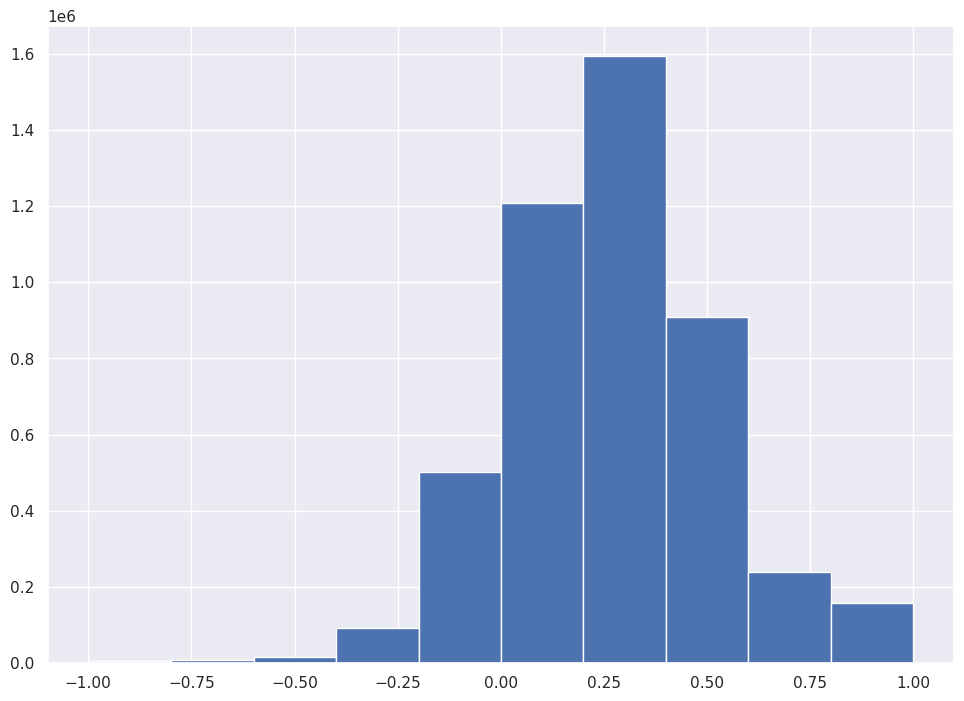

In [27]:
plt.hist(reviews["polarity"])
plt.show()

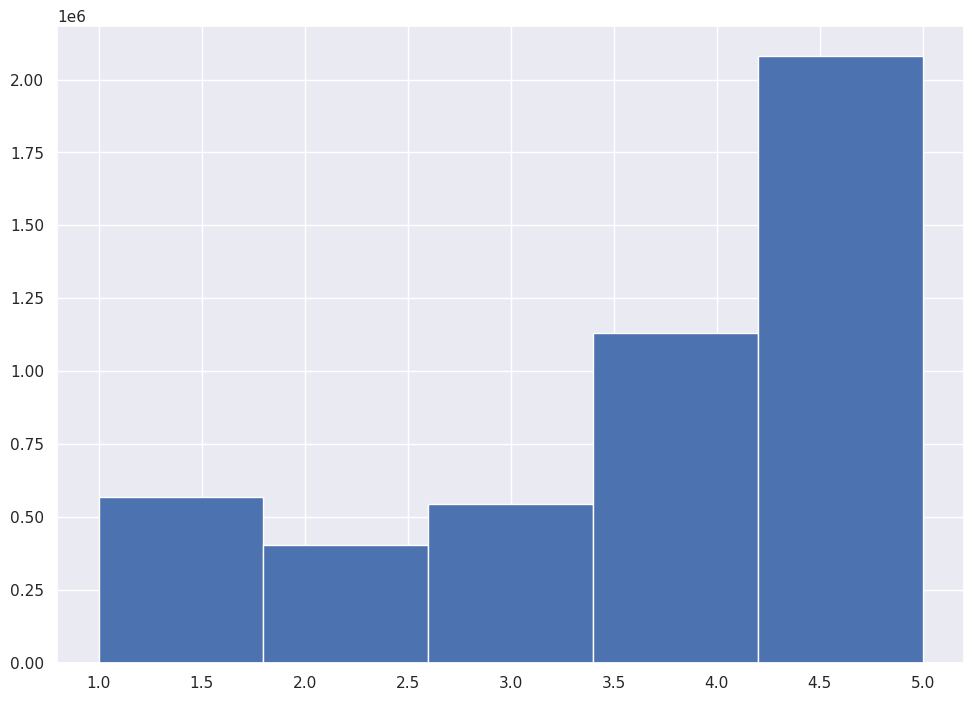

In [30]:
plt.hist(reviews["stars"], bins=5)
plt.show()

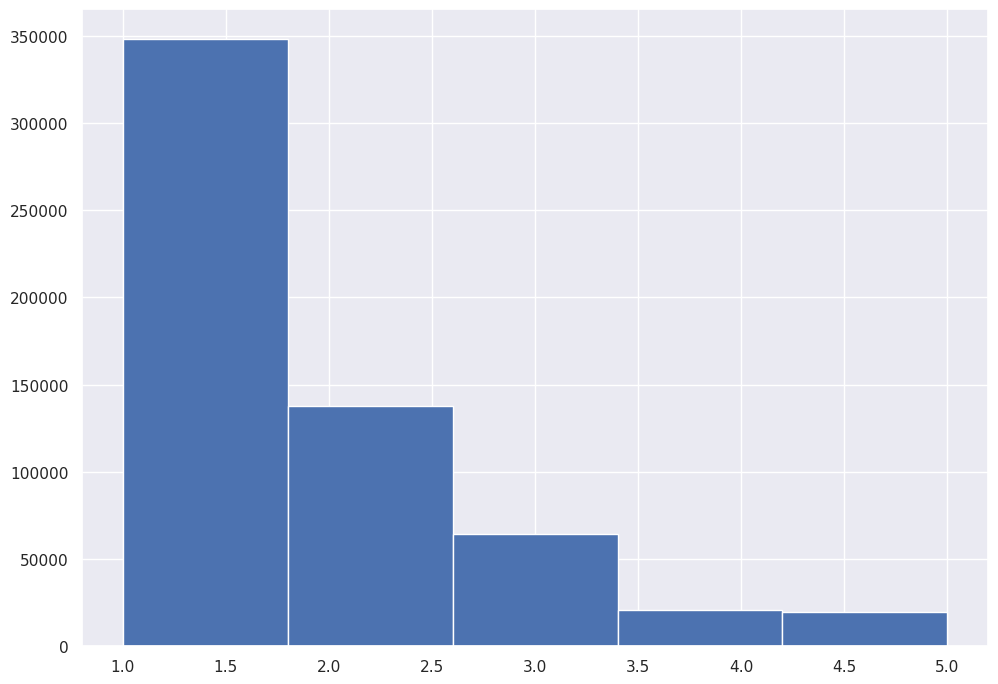

In [32]:
#Looking at the star ratings over reviews with less than 0 polarity
plt.hist(reviews[reviews.polarity < 0]["stars"], bins=5)
#This mostly validates our polarity scoring methodology
plt.show()

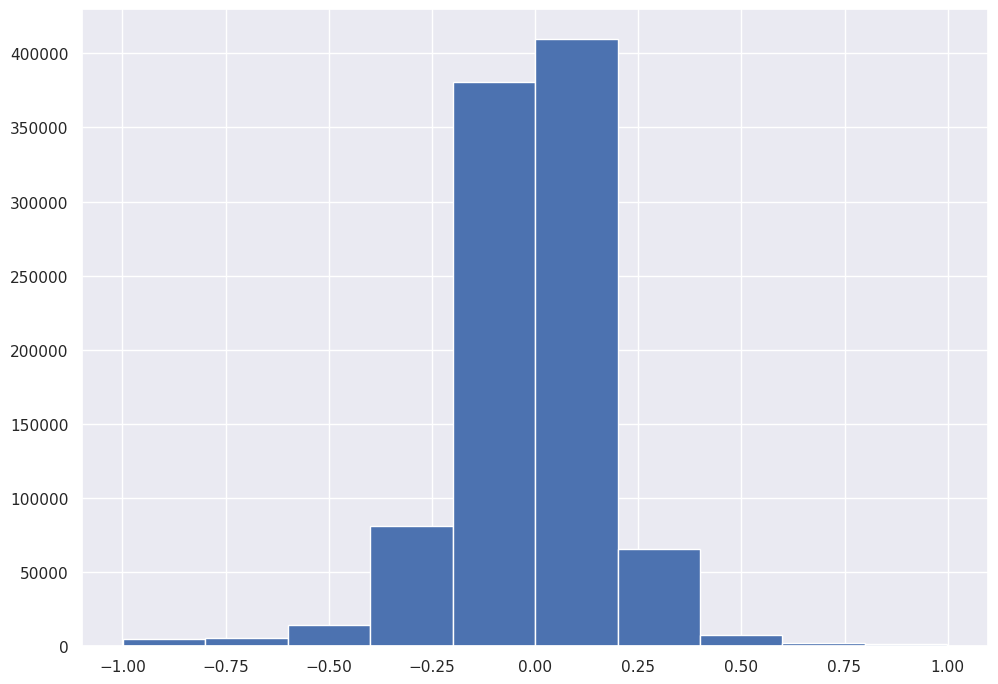

In [33]:
#Looking at the polarity of reviews with 1 or 2 stars
plt.hist(reviews[reviews.stars < 3]["polarity"], bins=10)
plt.show()

In [14]:
#Since we want to keep only topics of dissatisfaction, we will only keep reviews with 1-2 stars with a negative polarity
df = reviews.loc[(reviews.polarity < 0) & (reviews.stars <= 2)].copy()

df["text"] = df["text"].apply(lambda x: str(x).lower())

df.shape

(486008, 8)

### Text Normalization

We will use Spacy to Lemmatize and Tokenize our dataset.

In [ ]:
import spacy
spacy.prefer_gpu()

#Using the trf model is too long, so we will use the sm model here, would need to be changed for production
#nlp = spacy.load("en_core_web_trf")
nlp = spacy.load("en_core_web_sm")

def lemmatize(x):
    doc = nlp(x)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    return ' '.join(tokens)

df["lemma_text"] = df["text"].apply(lemmatize)

df.head()

In [ ]:
#Saving our lemmatized reviews file
with open('Data/lemmma_reviews.pkl', 'wb') as file:
    dill.dump(df, file)

In [ ]:
from bertopic import BERTopic
import hdbscan
%set_env TOKENIZERS_PARALLELISM=True

# -- Custom HDBSCAN
bertopic_params = {}
bertopic_params['hdbscan_model'] = hdbscan.HDBSCAN(min_cluster_size=10,
                                                   metric='euclidean',
                                                   cluster_selection_method='eom',
                                                   prediction_data=True,
                                                   core_dist_n_jobs=1)  # TODO should prevent error

topic_model = BERTopic(language="english", verbose=True, **bertopic_params)
topics, probs = topic_model.fit_transform(df["lemma_text"].to_list())

env: TOKENIZERS_PARALLELISM=True


Batches:   0%|          | 0/15188 [00:00<?, ?it/s]

2022-10-09 10:38:10,886 - BERTopic - Transformed documents to Embeddings
2022-10-09 10:44:24,573 - BERTopic - Reduced dimensionality
